# Max infection peak vs q for different system size

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 100
nSaveSteps: 1
nRuns: 10
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: true
comorbidities: false
qVoterParameters:
  p: 0.2
  q: 6
epidemicLayerParameters:
  beta: 0.1
  zeta: 0.0
  alpha: 0.0
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 1.0 # all agents +1
proPisFraction: 0.0
pisVaccinationCorrelation: 0.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/max_infection_peak_vs_q_nruns_10
firstParameterRange:
  start: 0.0
  end: 0.5
  count: 51
  vals: [0.01, 0.1, 0.5]
  type: beta
secondParameterRange:
  start: 0
  end: 0
  count: 0
  vals: [0.01, 0.05, 0.1, 0.3, 0.5]
  type: p
thirdParameterRange:
  start: 0
  end: 0
  count: 0
  vals: [2, 3, 4, 5, 6, 7, 8, 9, 10]
  type: q
linksRemoval: false
nQVoterPerStep: 1
vaccinationFraction: 0.0
```

> ╰─ python scripts/run_modify_config.py "config/max_infection_peak_vs_q.yaml" ":positiveOpinionFraction=1.0" "off"


In [51]:
def load_df(prefix, beta, folder, p, nagents=10000, fracPos=1.0, q=6, qvotersteps=1, nsteps=100, nruns=10):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_INFECTED=0.1_QVOTER=p={p}_q={q}_PIS=0.0_EPIDEMIC=beta={beta}_zeta=0,00_alpha=0,00_gamma=0,50_mu=0,90_kappa=0,10_QVOTERSTEPS={qvotersteps}_NRUN={n}.tsv"
        #path = path.replace(',', '.')
        
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    columns = [f'{s}Std' for s in df.columns]
    dfs1Std = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).std(axis=0),
                        index=df.index, 
                        columns=columns)
    dfs1Std['step'] = dfs1['step']
    dfs1 = dfs1.merge(dfs1Std, on='step')
    return dfs1

betas = ['0.01', '0.10', '0.50']
betas_float = [float(b) for b in betas]
betas = [b.replace('.', ',') for b in betas]

# ps = ['0.01', '0.05', '0.10', '0.30', '0.50']
# ps = ['0,01', '0,05', '0,10', '0,30', '0,50'] # I limit p values
ps = ['0,01', '0,10', '0,50']


qs = [2, 3, 4, 5, 6, 7, 8, 9, 10]

print('ps: ', ps)
print('Betas: ', betas, len(betas))

ps:  ['0,01', '0,10', '0,50']
Betas:  ['0,01', '0,10', '0,50'] 3


In [52]:
def load_dfs(beta, ps=ps, qs=qs, path='max_infection_peak_vs_q_nruns_10', prefix='off'):
    """
    { N: list of dataframes, one per `beta` value }
    
    e.g.

    {size: [pd.DataFrame(beta=0.00), pd.DataFrame(beta=0.01), ...]}
    """
    xs = {}
    for p in tqdm(ps):
        xs_per_p = []
        for q in qs:
            df1 = load_df(prefix, beta, path, p, q=q)
            xs_per_p.append(df1)
        xs[p] = xs_per_p
    return xs


def load_all_dfs(betas):
    """
    { qvoterstep: {beta: list of dataframes}, ... }
    """
    df_per_beta = {}
    for beta in betas:
        df_per_beta[beta] = load_dfs(beta)
    return df_per_beta

In [53]:
%%time


dfs_betas = load_all_dfs(betas)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 6.13 s, sys: 34.9 ms, total: 6.16 s
Wall time: 6.12 s


In [54]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# colors = ['red', 'green', 'blue', 'purple', 'brown']
colors = ['golden yellow', 'soft purple', 'red', 'true blue', 'grass']
colors = ['xkcd:' + c for c in colors]
# markers = ['o', 'v', '^', 'D', 's']
markers = ['o', 'X', 's', 'v', '^']

def max_infection_rate(df):
    return df['infectedRate'].max()

def max_infection_rate_std(df, fun):
    return df['infectedRateStd'][df['infectedRate'] == fun(df)].values[0]

def max_quarantine_rate(df):
    return df['quarantinedRate'].max()

def last_opinion(df):
    return df['meanOpinion'].to_numpy()[-1]

def last_recovered_rate(df):
    return df['recoveredRate'].to_numpy()[-1]

def time_max_infection(df):
    return df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]


def plot_max_infection_peak_vs_q_per_p(dfs, color, betas_float=betas_float, markers=markers, 
                                       fun=max_infection_rate):
    i = 0
    markers_legend = []
    for p, df in dfs.items():
        peaks = [fun(x) for x in df]
        peaks_std = [max_infection_rate_std(x, fun) for x in df]
#         plt.errorbar(betas_float, peaks, yerr=peaks_std, fmt='o', linewidth=1, color=color, 
#                      marker=markers[i], mfc='none', alpha=0.9, label=rf'$N={{{size}}}$')
        plt.scatter(betas_float, peaks, s=60, label=rf'$N={{{size}}}$', color=color, 
                    marker=markers[i], facecolors='none', alpha=0.9)
        plt.plot(betas_float, peaks, '-', linewidth=1, color=color, alpha=0.3)
        
        l = Line2D([0], [0], marker=markers[i], color='black', label=rf'$N={{{size}}}$',
                    markersize=12, mfc='none', linestyle='')
        markers_legend.append(l)
        i += 1
    
    plt.xlabel(r'$\beta$', fontsize=24)
    plt.ylabel(r'$I_{max}$', fontsize=24) # max infection rate
    return markers_legend
    
def plot_max_infection_peak_vs_beta_per_p(dfs_ps, fun=max_infection_rate, add_legend=True):
    i = 0
    
    patches = []
    markers_legend = None
    for p, dfs in dfs_ps.items():
        markers_legend = plot_max_infection_peak_vs_beta_per_beta(dfs, colors[i], fun=fun)
        
        patch = Patch(facecolor=colors[i], label=rf"$p={{{p.replace(',', '.')}}}$")
        patches.append(patch)
        i += 1
        
    p_empty = Patch(facecolor='w', label='', alpha=0.0)
    
    legend_elements = [p_empty, p_empty, *markers_legend, *patches]
    if add_legend:
        plt.legend(handles=legend_elements, ncol=2, columnspacing=1.0)
#         plt.legend(handles=legend_elements, ncol=1, columnspacing=0.5)

In [72]:
def plot_max_infection_vs_q_per_beta(dfs, add_legend=False):
    i = 0
    for p, dfs in dfs.items():
        peaks = [max_infection_rate(df) for df in dfs]
        peaks_std = [max_infection_rate_std(x, max_infection_rate) for x in dfs]
        plt.scatter(qs, peaks, s=80, label=rf'$p={{{p.replace(",", ".")}}}$', color=colors[i], 
                    marker=markers[i], alpha=1.0, edgecolor='black')
        #plt.plot(qs, peaks, color=colors[i], alpha=0.5)        
        plt.errorbar(qs, peaks, yerr=peaks_std, color=colors[i], alpha=0.5)        
        
        i += 1
    if add_legend:
        plt.legend(fontsize=18, loc='center', handletextpad=0.02)
    
    plt.xlabel(r'$q$', fontsize=24)
    plt.ylabel(r'$I_{max}$', fontsize=24)
    plt.xticks(range(2, 11), range(2, 11))

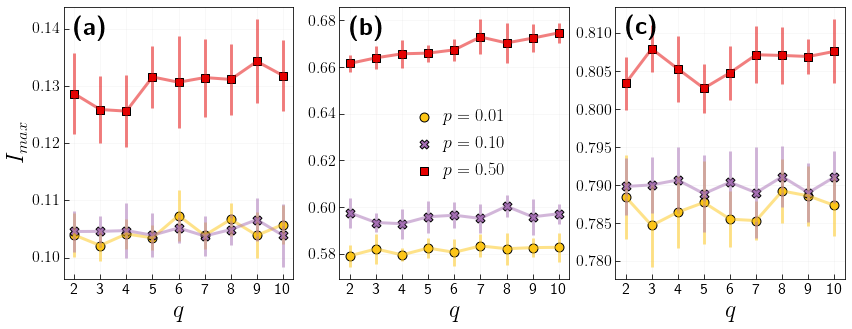

In [80]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plot_max_infection_vs_q_per_beta(dfs_betas['0,01']) # beta = 0.01
plt.text(2, 0.139, r'\textbf{(a)}', fontsize=25)

plt.subplot(1, 3, 2)
plot_max_infection_vs_q_per_beta(dfs_betas['0,10'], add_legend=True) # beta = 0.10
plt.ylabel('')
plt.text(2, 0.674, r'\textbf{(b)}', fontsize=25)

plt.subplot(1, 3, 3)
plot_max_infection_vs_q_per_beta(dfs_betas['0,50']) # beta = 0.50
plt.ylabel('')
plt.text(2, 0.810, r'\textbf{(c)}', fontsize=25)

# plt.savefig("../plots/paper/imax_vs_q.pdf")

In [81]:
# INFO: could be wrong !!!
def plot_per_p(dfs_ps, beta, add_legend=False):
    i = 0
    markers_legend = None
    patches = []
    for p in ps:
        j = 0
        markers_legend = []
        for n in sizes:
            df = dfs_ps[p][n][betas.index(beta)]
            x = [0] + list(df.step + 1)
            y = [0.1] + list(df.infectedRate)
            plt.plot(x, y, 'o--', label=f'p={p}', linewidth=1, color=colors[i],
                     marker=markers[j], mfc='none', markersize=6)
            l = Line2D([0], [0], marker=markers[j], color='black', label=f'N={n}',
                       markersize=12, mfc='none', linestyle='')
            markers_legend.append(l)
            j += 1
        patch = Patch(facecolor=colors[i], label=f'p={p}')
        patches.append(patch)
        i += 1
    plt.ylabel(r'$I$')
    plt.xlabel(r'$t$')
    plt.title(r'$\beta={}$'.format(beta.replace(',', '.')))
    plt.xlim(-1, 45)
    
    p_empty = Patch(facecolor='w', label='')
    legend_elements = [*markers_legend, p_empty, *patches]
    if add_legend:
        plt.legend(handles=legend_elements, ncol=1)


# plt.figure(figsize=(10, 10))
# plt.subplot(2, 2, 1)
# plot_per_p(dfs_ps, beta='0.01')
# plt.xlabel('')

# plt.subplot(2, 2, 2)
# plot_per_p(dfs_ps, beta='0.02')
# plt.xlabel('')
# plt.ylabel('')

# plt.subplot(2, 2, 3)
# plot_per_p(dfs_ps, beta='0.05')

# plt.subplot(2, 2, 4)
# plot_per_p(dfs_ps, beta='0.20', add_legend=True)
# plt.ylabel('')